<a href="https://colab.research.google.com/github/emicervantes/wound_classification/blob/main/wound_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

#### Load wound data

In [2]:
X = np.load('wound_features.npy', encoding = 'bytes')
Y = np.load('wound_label.npy', encoding = 'bytes')

In [15]:
Y[Y == 0] = 2

In [16]:
np.unique(Y, return_counts = True)

(array([1, 2, 3, 4, 5]), array([154, 200, 100, 128, 156]))

In [3]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30)

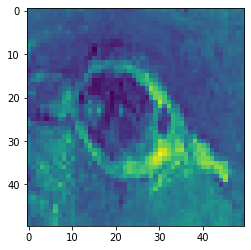

In [4]:
plt.imshow(x_train[3,:,:,0])

In [ ]:
len(np.unique(Y))

6

#### CNN Using Keras

In [5]:
model = Sequential()
model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

model.fit(X, Y, batch_size = 32, epochs = 10, validation_split = 0.1)

Epoch 1/10
21/21 [==============================] - 7s 252ms/step - loss: 0.0000e+00 - accuracy: 0.2063 - val_loss: 0.0000e+00 - val_accuracy: 0.2297
Epoch 2/10
21/21 [==============================] - 4s 193ms/step - loss: 0.0000e+00 - accuracy: 0.2063 - val_loss: 0.0000e+00 - val_accuracy: 0.2297
Epoch 3/10
21/21 [==============================] - 4s 188ms/step - loss: 0.0000e+00 - accuracy: 0.2063 - val_loss: 0.0000e+00 - val_accuracy: 0.2297
Epoch 4/10
21/21 [==============================] - 4s 188ms/step - loss: 0.0000e+00 - accuracy: 0.2063 - val_loss: 0.0000e+00 - val_accuracy: 0.2297
Epoch 5/10
21/21 [==============================] - 4s 194ms/step - loss: 0.0000e+00 - accuracy: 0.2063 - val_loss: 0.0000e+00 - val_accuracy: 0.2297
Epoch 6/10
21/21 [==============================] - 4s 188ms/step - loss: 0.0000e+00 - accuracy: 0.2063 - val_loss: 0.0000e+00 - val_accuracy: 0.2297
Epoch 7/10
21/21 [==============================] - 4s 189ms/step - loss: 0.0000e+00 - accuracy: 0.2

### CNN Using Torch

In [6]:
# Check GPU avialbility
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
# Hyper parameters
num_epochs = 5
num_classes = 6
batch_size = 100
learning_rate = 0.0001

In [21]:
torch_XTr = torch.tensor(x_train)
torch_YTr = torch.tensor(y_train)
torch_XTe = torch.tensor(x_test)
torch_YTe = torch.tensor(y_test)

train = torch.utils.data.TensorDataset(torch_XTr, torch_YTr)
train_loader = torch.utils.data.DataLoader(train, batch_size= batch_size, shuffle = True)

test = torch.utils.data.TensorDataset(torch_XTe, torch_YTe)
test_loader = torch.utils.data.DataLoader(test, batch_size= batch_size, shuffle = False)

X, Y = next(iter(train_loader))
print(X.shape, Y.shape)

torch.Size([100, 50, 50, 3]) torch.Size([100])


In [22]:
X = torch.swapaxes(X, 1,3)
X.shape

torch.Size([100, 3, 50, 50])

In [27]:
# Hyper parameters
num_epochs = 50
num_classes = 5
batch_size = 100
learning_rate = 1e-5

In [ ]:
# CNN
class ConvNet(nn.Module):
  def __init__(self, num_classes = 6):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size = 5, stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size = 5, stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)  
    )
    self.fc = nn.Linear(4608, num_classes)

  def forward(self, x):
    out = self.layer1(x.float())
    print(out.shape)
    out = self.layer2(out)
    print(out.shape)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    return out

In [18]:
class ConvNet(nn.Module):
  def __init__(self, num_classes = 5):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 4, stride = 1, padding = 2),
        nn.BatchNorm2d(64),        
        nn.Tanh(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size = 4, stride = 1, padding = 2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)  
    )
    self.fc = nn.Linear(21632, num_classes)

  def forward(self, Xfe):
    out = self.layer1(Xfe.float())    
    out = self.layer2(out)   
    out = out.reshape(out.size(0), -1)    
    out = self.fc(out)
    return out

In [19]:
model = ConvNet(num_classes)
output = model(torch_XTr)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [30]:
total_step = len(train_loader)
#num_epochs = 5
model.train()
for epoch in range(num_epochs):    
    for i, (X, Y) in enumerate(train_loader):
        X = torch.swapaxes(X, 1,3)
        # Forward pass       
        outputs = model(X)   

        # Calculate Loss     
        loss = criterion(outputs, Y)

        # Backward and optimize   
        optimizer.zero_grad()     
        loss.backward()
        optimizer.step()       

        #store loss and iteration
        
        if (i+1) % 6 == 0:
            #print('Iteration: {} Loss: {} '.format(count, loss.item()))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                  .format(epoch+1, num_epochs, (i+1), total_step, loss.item()))


Epoch [1/50], Step [6/6], Loss: 0.0210
Epoch [2/50], Step [6/6], Loss: 0.0051
Epoch [3/50], Step [6/6], Loss: 0.1416
Epoch [4/50], Step [6/6], Loss: 0.0406
Epoch [5/50], Step [6/6], Loss: 0.0146
Epoch [6/50], Step [6/6], Loss: 0.0101
Epoch [7/50], Step [6/6], Loss: 0.0094
Epoch [8/50], Step [6/6], Loss: 0.0140
Epoch [9/50], Step [6/6], Loss: 0.0283
Epoch [10/50], Step [6/6], Loss: 0.0384
Epoch [11/50], Step [6/6], Loss: 0.1108
Epoch [12/50], Step [6/6], Loss: 0.0526
Epoch [13/50], Step [6/6], Loss: 0.0136
Epoch [14/50], Step [6/6], Loss: 0.0366
Epoch [15/50], Step [6/6], Loss: 0.0092
Epoch [16/50], Step [6/6], Loss: 0.0075
Epoch [17/50], Step [6/6], Loss: 0.0042
Epoch [18/50], Step [6/6], Loss: 0.0121
Epoch [19/50], Step [6/6], Loss: 0.0063
Epoch [20/50], Step [6/6], Loss: 0.0667
Epoch [21/50], Step [6/6], Loss: 0.0596
Epoch [22/50], Step [6/6], Loss: 0.0270
Epoch [23/50], Step [6/6], Loss: 0.1168
Epoch [24/50], Step [6/6], Loss: 0.0129
Epoch [25/50], Step [6/6], Loss: 0.0048
Epoch [26

In [31]:
model.eval()
testmod_acc = []
with torch.no_grad():    
    for X, Y in test_loader:
        X = torch.swapaxes(X, 1,3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        testmod_acc.append((predicted == Y).sum().item() / predicted.size(0))
        

    print('Test Accuracy of the model = {} %'.format(100*np.mean(testmod_acc)))

Test Accuracy of the model = 62.39393939393939 %
